# Segmentation
(teaching: 15 minutes)

## Questions:
- "How can we segment an image into different sections?"

## Objectives:
- "Understand the prinicples behind the median Otsu segmentation algorithm"
- "Use scikit-image to perform histogram-based segmentation"
- "Use scikit-image to perform edge-based segmentatio"

## Key points:
- "There are (at least) three different ways to perform segmentation"
- "The first uses the histogram of the pixel gray values"
- "The second detects edges and fills between them"

Segmentation is a basic operation in image processing. Very often, we will want
to use image information in order to differentiate between different parts of
the image as belonging to different objects, or different classes.

We will talk about two different ways of segmenting an image. Neither of them
will be particularly good, but they will at least teach you how to think about
image processing.

We will use [`scikit-image`](http://scikit-image.org/) to perform these
operations.

But first, let's get the data using `nibabel`

In [1]:
import os.path as op
import dipy.data as dpd
remote, local = dpd.fetch_stanford_t1()
t1_file = op.join(local, 't1.nii.gz')

Dataset is already in place. If you want to fetch it again please first remove the folder /home/jovyan/.dipy/stanford_hardi 


In [2]:
import nibabel as nib

t1_img = nib.load(t1_file)
t1_data = t1_img.get_data()

### Histogram-based segmentation

One way of segmenting an image is to look at the histogram of the pixel
intensities and differentiate between classes. Let's examine the histogram:

In [3]:
from skimage import exposure
import matplotlib.pyplot as plt
%matplotlib inline

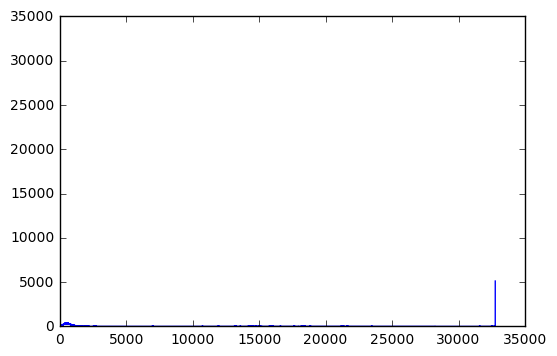

In [4]:
hist, bin_centers = exposure.histogram(t1_data.ravel())
fig, ax = plt.subplots(1)
ax.plot(bin_centers, hist)

In [5]:
import numpy as np
t1_norm = (t1_data - np.mean(t1_data))/np.std(t1_data)

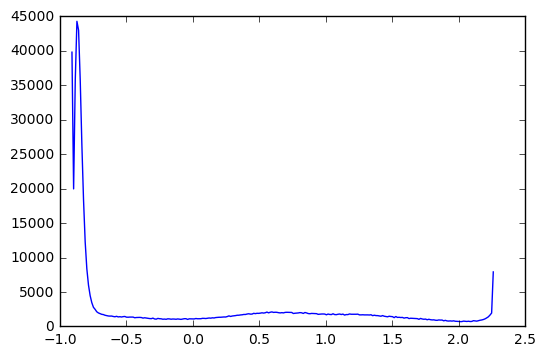

In [6]:
hist, bin_centers = exposure.histogram(t1_norm.ravel())
fig, ax = plt.subplots(1)
ax.plot(bin_centers, hist)

There are several different methods that use the histogram to perform
segmentation. We'll closely examine one of these algorithms that is a classic
algorithm designed by Nobuyuki Otsu, a Japanese Engineer, back in the 1970's

### Otsu's method for segmentation

https://en.wikipedia.org/wiki/Otsu%27s_method

Assumes there are two classes of voxels: background and foreground. The
algorithm attempts to set a threshold in the histogram, such that the variance
within each class of the image is minimized.

The class probabilities as a function of the threshold $t$ are the cumulative
sums of the distributions up to that point:

$$w_1(t) = \sum_{i=1}^{t-1} \frac{hist(i)}{L}$$

$$w_2(t) = \sum_{i=t}^{L-1} \frac{hist(i)}{L} $$

where L is the total number of pixels

That looks like this:

In [7]:
# Normalize the histogram to sum to 1:
hist = hist.astype(float) / np.sum(hist)

# class probabilities for all possible thresholds
weight1 = np.cumsum(hist)
weight2 = np.cumsum(hist[::-1])[::-1]

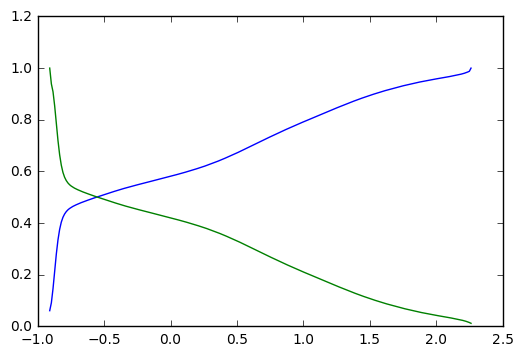

In [8]:
#Plotting this:
fig, ax = plt.subplots(1)
ax.plot(bin_centers, weight1)
ax.plot(bin_centers, weight2)

Recall that we are trying to minimize the intra-class variance:

Otsu's method relies on finding a threshold that  minimizes the intra-class
variance:

$$\sigma^2_w = w_1 \sigma^2_1 + w_2 \sigma^2_2$$

But minimizing intra-class variance is equivalent to maximazing inter-class

Importantly, minimizing intra-class variance, is equivalent to maximizing inter-class variance.

That is becauase:

$$\sigma^2 = \sigma^2_w + \sigma^2_b$$

That's because the sum of squares is always constant:

$$\sigma^2_b = \sigma^2 - \sigma^2_w$$

The inter-class variance can be written as:

$$w_1 (\mu_1 - \mu)^2 + w_2 (\mu_2 - \mu)^2 = w_1 w_2 (\mu_1 - \mu_2)^2$$


Where

$$\mu_1 = \sum_{i}^{t-1} \frac{i p(i)}{w_1}$$

$$\mu_2 = \sum_{t}^{L-1} \frac{i p(i)}{w_2}$$

The advantage of this formulation is that it can be written in code that can
run fast.

We start by setting the means of the background/foreground for all possible
thresholds:

In [9]:
# class means for all possible thresholds
mean1 = np.cumsum(hist * bin_centers) / weight1
mean2 = (np.cumsum((hist * bin_centers)[::-1]) / weight2[::-1])[::-1]

Plotting this:

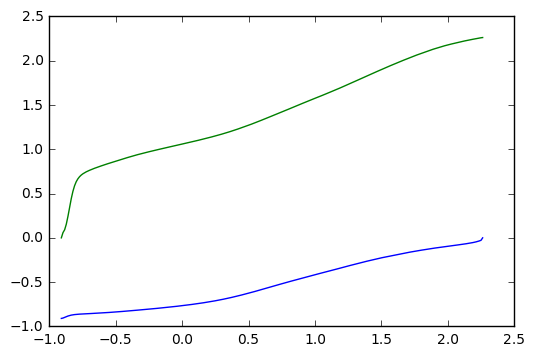

In [10]:
#Plotting this:
fig, ax = plt.subplots(1)
ax.plot(bin_centers, mean1)
ax.plot(bin_centers, mean2)

And calculate the inter-class variance:

In [11]:
# The last value of `weight1`/`mean1` should pair with zero values in
# `weight2`/`mean2`, which do not exist.
variance12 = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2

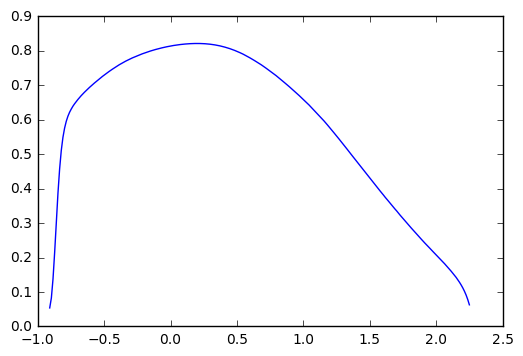

In [12]:
fig, ax = plt.subplots(1)
ax.plot(bin_centers[:-1] ,variance12)

To find the threshold value that marks the distinction between the two classes
we detect the maximum of this function:

In [13]:
idx = np.argmax(variance12)
threshold = bin_centers[:-1][idx]

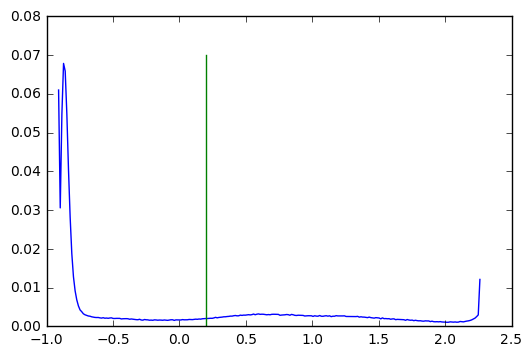

In [14]:
fig, ax = plt.subplots(1)
ax.plot(bin_centers, hist)
ax.plot([threshold, threshold], [0, ax.get_ylim()[1]])

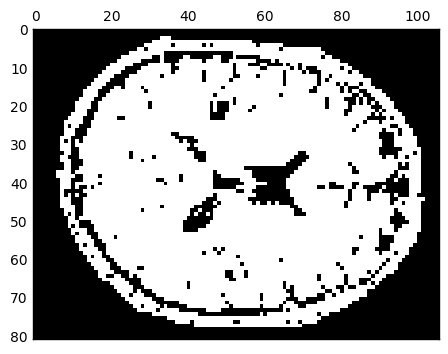

In [15]:
binary = t1_norm >= threshold
fig, ax = plt.subplots()
ax.matshow(binary[:, :, binary.shape[-1]//2], cmap='bone')

This looks like it can (in this case, easily...) separate background from
foreground. Can we do any better with a histogram-based segmentation. For
example, do you think that it would be possible to strip the skull off with this
type of algorithm?

The `filters` module in `scikit-image` contains a variety of thresholding algorithms. You can try all of them by running:

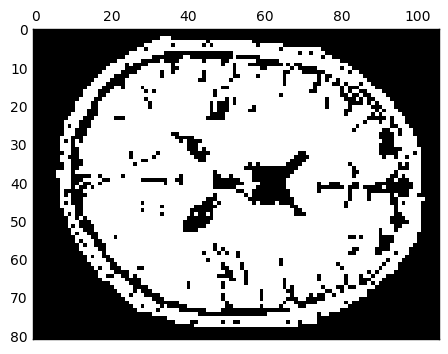

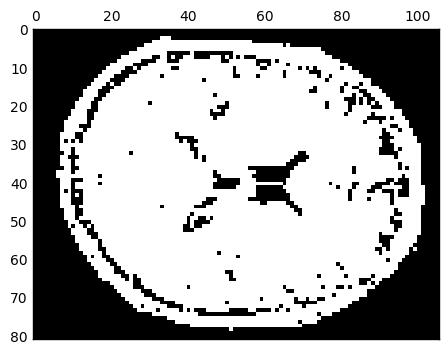

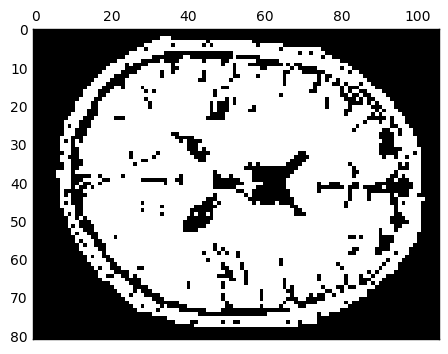

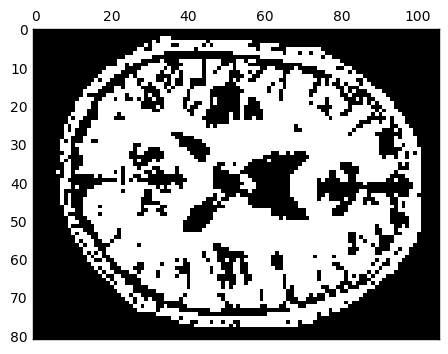

In [16]:
from skimage import filters
for threshold in [filters.threshold_isodata, 
                  filters.threshold_li,
                  filters.threshold_otsu, 
                  filters.threshold_yen]:

    fig, ax = plt.subplots(1)
    th = threshold(t1_data[:, :, t1_data.shape[-1]//2])
    binary = t1_data >= th
    ax.matshow(binary[:, :, binary.shape[-1]//2], cmap='bone')

## Edge-based segmentation

Another way to segment an image is based on detecting edges in the image, and
filling between these edges. Detecting images is part of a larger set of
operations that can be done on image: detecting image features.

The module that does these operations is `skimage.feature`:

In [17]:
from skimage import feature

Unfortunately, these algorithms usually only work on 2D images, so we'll work
on one slice from now on:

In [18]:
im = t1_data[:, :, t1_data.shape[-1]//2]

A classic edge detection algorithm is the Canny filter.

The performance of the algorithm depends strongly on the sigma parameter, which
corresponds to the width of a Gaussian smoothing kernel that is applied to the image before edges are detected.

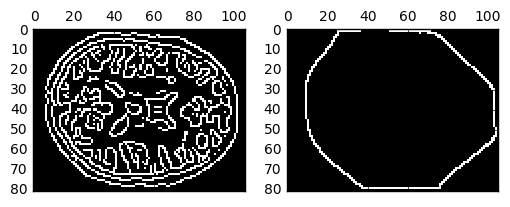

In [19]:
edges1 = feature.canny(im, sigma=1)
edges7 = feature.canny(im, sigma=7)
fig, ax = plt.subplots(1, 2)
ax[0].matshow(edges1, cmap='bone')
ax[1].matshow(edges7, cmap='bone')

Scikit image works well together with the image processing tools that are
implemented in scipy. We use these to dilate the edges slightly and fill the
holes in the image:

In [20]:
from scipy import ndimage as ndi
dilated = ndi.binary_dilation(edges7, iterations=4)
fill_brain = ndi.binary_fill_holes(dilated)

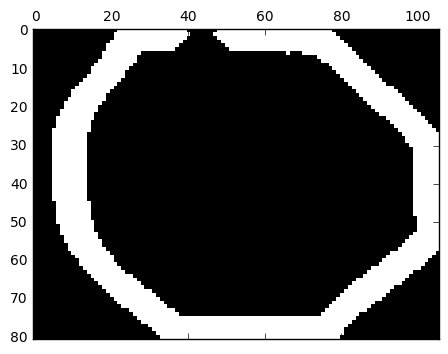

In [21]:
fig, ax = plt.subplots(1)
ax.matshow(fill_brain, cmap='bone')

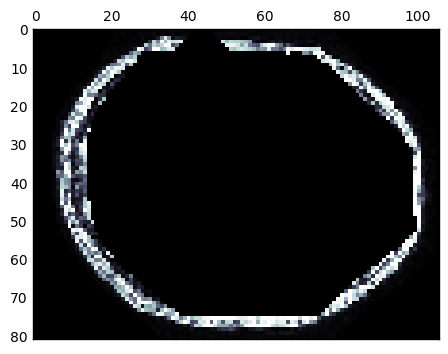

In [22]:
brain = np.zeros(im.shape)
brain[fill_brain] = im[fill_brain]
fig, ax = plt.subplots(1)
ax.matshow(brain, cmap='bone')

This works rather well in detecting the parts of the image that contain the skull!

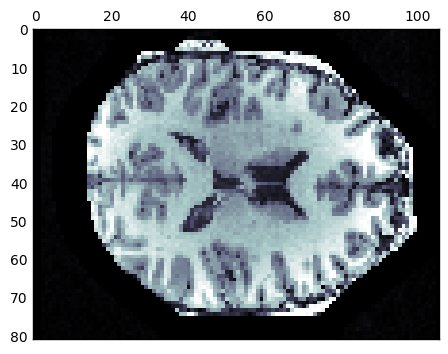

In [23]:
brain = np.copy(im)
brain[fill_brain] = 0
fig, ax = plt.subplots(1)
ax.matshow(brain, cmap='bone')

This is in the right direction, but is not good enough.

Another approach to segmentation is a so-called watershed approach. 

In this approach we define gradients of change in the image and use these as cues to a "flooding" process. The algorithm treats the image as a series of valleys and will not cross the watersheds between them.

/opt/conda/lib/python3.5/site-packages/skimage/util/dtype.py:111: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


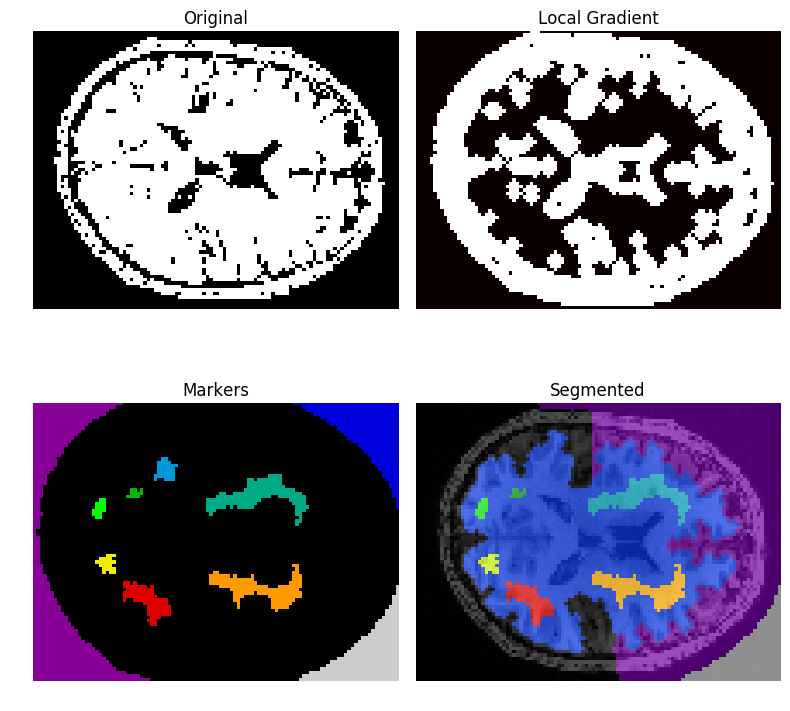

In [24]:
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

from skimage.morphology import watershed, disk
from skimage import data
from skimage.filters import rank
from skimage.util import img_as_ubyte

image = np.zeros(im.shape)
th_otsu = filters.threshold_otsu(im)
image[im>th_otsu] = 1

# find continuous region (low gradient -
# where less than 10 for this image) --> markers
# disk(5) is used here to get a more smooth image
markers = rank.gradient(image, disk(5)) < 10
markers = ndi.label(markers)[0]

# local gradient (disk(2) is used to keep edges thin)
gradient = rank.gradient(image, disk(2))

# process the watershed
labels = watershed(gradient, markers)

# display results
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), sharex=True, 
                         sharey=True, subplot_kw={'adjustable':'box-forced'})
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title("Original")

ax[1].imshow(gradient, cmap=plt.cm.hot, interpolation='nearest')
ax[1].set_title("Local Gradient")

ax[2].imshow(markers, cmap=plt.cm.spectral, interpolation='nearest')
ax[2].set_title("Markers")

ax[3].imshow(im, cmap=plt.cm.gray, interpolation='nearest')
ax[3].imshow(labels, cmap=plt.cm.spectral, interpolation='nearest', alpha=.7)
#ax[3].imshow(labels<3, cmap=plt.cm.bone, interpolation='nearest', alpha=.7)
ax[3].set_title("Segmented")

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

This works much better!

## You don't really need to roll your own

Dipy has developed an algorithm based on iterative application of the Otsu algorithm and a median filter, shown below:

In [25]:
from dipy.segment.mask import median_otsu
t1_mask, mask = median_otsu(t1_data)

/opt/conda/lib/python3.5/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


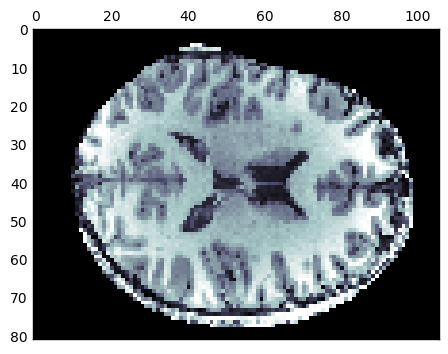

In [26]:
fig, ax = plt.subplots(1)
ax.matshow(t1_mask[:, :, t1_mask.shape[-1]//2], cmap='bone')

## Conclusions

You can use any one of these approaches, but you will find that often it is necessary to construct a pipeline of image operations: filtering, segmentation, feature-detection etc. in order to process your image and detect.